In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Exercise 6.1 (Bayesian Inference with SNIS)

In this exercise, we will use our toy Gaussian model to perform Bayesian inference. We will use the same model as in **Example 3.6**. Recall that this model is given as:

- `p(x) = N(x; mu_0, sigma_0^2)`
- `p(y_i | x) = N(y_i; x, sigma^2)`

where `i = 1, ..., M`, i.e., `y_i` are conditionally independent given `x`.

In the first implementation of this exercise, you can set `mu_0 = 0`, `sigma^2 = 1`, and `sigma_0^2 = 1`, but you should also explore other parameters to gain intuition.

### Instructions

1. **Simulate Data**  
   - Simulate `M = 1000` data points from this model.  
   - Perform `X ~ p(x)` and then fix the sample `X = x`.  
   - For `i = 1, ..., M`, sample `y_i ~ p(y_i | x)`.


In [5]:
N = 1000
mu_0 = 0
sigma_0, sigma = 1, 1

rng = np.random.default_rng(25)
x = rng.normal(mu_0, sigma_0)
y = rng.normal(x, sigma, N)
y[0:10]

array([ 0.34907432, -0.17755834, -1.92252678,  0.37275506,  1.2814085 ,
        1.3973744 , -0.18215838,  2.58340351,  2.29773166,  0.12581353])

2. For these particular datapoints, compute the true posterior mean estimate using the
expression `µp` in Example 3.6. This is the true posterior mean estimate for this model.

In [4]:
mean = (sigma_0**2 * np.sum(y) + sigma**2 * mu_0) / (sigma_0**2 * N + sigma**2)
mean

0.3938362645431516

3. Estimating the Posterior Mean with SNIS

Now we will use Self-Normalized Importance Sampling (SNIS) to estimate the posterior mean. For this, we will use the following proposal distribution:

- `q(x) = N(x; mu_q, sigma_q^2)`

In the first implementation, you can set `mu_q = 0` and `sigma_q^2 = 1`, but you should also explore other parameters to gain intuition.

### Instructions

1. **Implement the SNIS Estimator**  
   - Note that the unnormalized posterior is given by:  
     ```
     p_bar(x | y1:n) = p(y1:n | x) * p(x) = (Product from i=1 to M of p(y_i | x)) * p(x)
     ```
     as described in Exercise 3.6.  

2. **Compute Weights in the Log-Domain**  
   - Implement the SNIS estimator for this model.  
   - Compute the weights both without using the log-trick and with the log-trick.

3. **Compare the Results**  
   - Compare the posterior mean estimates obtained using the two methods.  
   - Observe that the log-trick is necessary to handle numerical stability in this model.


In [8]:
# define log prior
def logp(x):
    return -x**2/2 - np.log(np.sqrt(2*np.pi))

# define log likelihood
def loglik(x, y):
    return -(x-y)**2/2 - np.log(np.sqrt(2*np.pi))

# define log proposal
def logq(x):
    return -x**2/2 - np.log(np.sqrt(2*np.pi))

def ESS(w):
    return 1/np.sum(w**2)

N = 10000

x = rng.normal(0, 1, N) # sample from q(x)

logW = np.zeros(N)
for i in range(N):
    logW[i] = np.sum(loglik(x[i], y)) + logp(x[i]) - logq(x[i])

log_hat_W = logW - np.max(logW)

def ws(N):
    x = rng.normal(0, 1, N) # sample from q(x)
    logW = np.zeros(N)
    for i in range(N):
        logW[i] = np.sum(loglik(x[i], y)) + logp(x[i]) - logq(x[i])
    log_hat_W = logW - np.max(logW)
    return np.exp( log_hat_W )/np.sum(np.exp( log_hat_W )) # weights with log-trick

w = ws(N) # weights with log-trick
w2 = np.exp(logW)/np.sum(np.exp(logW)) # weights without logtrick


# mean estimate
mean = np.sum(w*x)
mean2 = np.sum(w2*x)

print("Mean estimate (stable): ", mean)
print("ESS: ", ESS(w))
print("Mean estimate (unstable): ", mean2)
print("ESS (unstable): ", ESS(w2))

Mean estimate (stable):  -0.014113945129087459
ESS:  425.4565324581858
Mean estimate (unstable):  nan
ESS (unstable):  nan


/tmp/ipykernel_2281/3132102560.py:35: RuntimeWarning: invalid value encountered in divide
  w2 = np.exp(logW)/np.sum(np.exp(logW)) # weights without logtrick


4. Finally compute effective sample size (ESS) and vary your N to see how it affects the
ESS. Plot the ESS w.r.t. N.

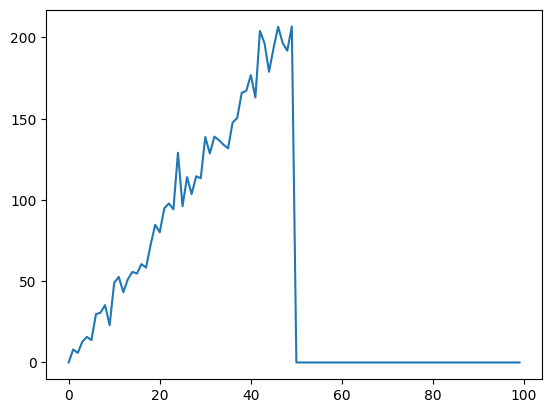

In [17]:
ess = np.zeros(100)
for i in range(1, 50):
    ess[i] = ESS(ws(100 * i))

plt.plot(ess)

# Exercise 6.2

In this example, we will work in **R²**.

## Problem Setup

### Prior

The **banana prior** is defined as:  
`p(x) ∝ exp(-x1² / 10 - x2² / 10 - 2 * (x2 - x1²)²)`,  
where x ∈ R².

### Likelihood

The **likelihood** is given by:  
`p(y | x) = N(y; Hx, σ² * I)`,  
where:  
- H = [1, 0]  
- y ∈ R  
- σ is the standard deviation.

## Given Data

- y = 1  
- σ = 0.05  

## Goal

Our goal is to sample from the posterior distribution `p(x | y)`.


1. Visualise the prior p(x). You will see that this gives you a 2D (unnormalised) density. Now try to interpret
our task. We assume that y = 1 with σ = 0.05.

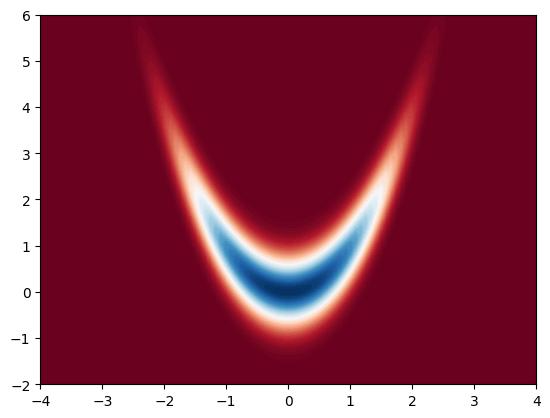

In [18]:
def bar_p(x):
    return np.exp(-x[0]**2/10 - x[1]**2/10 - 2 * (x[1] - x[0]**2)**2)

x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
# evaluate barp on this grid
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = bar_p([X_bb[i, j], Y_bb[i, j]])
# plot barp
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.show()


2. Now we will use SNIS to estimate the posterior mean. For this, we will use the
following proposal `q(x) = N (x; µq, σ2qI)`. Note that this is also defined on `R^2`
and you can set `µq = [0, 0` and `σ2q = 1`. 
Compute the posterior mean using SNIS (do not forget using log-prior and log-likelihood
and performing the log-trick) and compute the ESS (choose varying N. Start with N = 1000)

In [19]:
def q(x):
    return np.exp(- x[0]**2/2 - x[1]**2/2) / (2 * np.pi)

def logbar_p(x):
    return - x[0]**2/10 - x[1]**2/10 - 2 * (x[1] - x[0]**2)**2

def loglik(y, x, sig):
    H = [1, 0]
    return -(y - H @ x)**2/(2 * sig **2) - np.log(sig * np.sqrt(2 * np.pi))

def logq(x):
    return - x[0]**2/2 - x[1]**2/2 - np.log(2 * np.pi)

def ESS(w):
    return 1/np.sum(w**2)

y = 1
sig = 0.05

N = 10000
rng = np.random. default_rng (25)
# sample from q
x = rng.normal(0, 1, (2, N)) # 2 x N matrix (2 dimensional , N samples)

# compute logW
logW = np.zeros(N)
for i in range(N):
    logW[i] = (loglik(y, x[:, i], sig)) + logbar_p(x[:, i]) - logq(x[:, i])

# compute log_hat_W
log_hat_W = logW - np.max(logW)
w = np.exp( log_hat_W )/np.sum(np.exp( log_hat_W ))

# compute mean estimate
mean = np.sum(w*x, axis=1)

print("Mean estimate: ", mean)
print("ESS: ", ESS(w))


Mean estimate:  [0.99474518 0.96558191]
ESS:  166.13314607029793
